<a href="https://colab.research.google.com/github/ChristianConchari/Strathospheric-ballon-earth-observation-gathered-imagery-classification-through-TinyML/blob/master/classification_model_ballon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries and loading the data

In [30]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from  tensorflow.keras import optimizers
from keras.utils.vis_utils import plot_model

In [31]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [32]:
!unzip /content/gdrive/MyDrive/training_data_balloon.zip
!unzip /content/gdrive/MyDrive/test_data_balloon.zip

Archive:  /content/gdrive/MyDrive/training_data_balloon.zip
replace training_data_balloon/1/1.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: training_data_balloon/1/1.png  
  inflating: training_data_balloon/1/29.png  
  inflating: training_data_balloon/1/27.png  
  inflating: training_data_balloon/1/2.png  
  inflating: training_data_balloon/1/25.png  
  inflating: training_data_balloon/1/3.png  
  inflating: training_data_balloon/1/4.png  
  inflating: training_data_balloon/1/5.png  
  inflating: training_data_balloon/1/6.png  
  inflating: training_data_balloon/1/7.png  
  inflating: training_data_balloon/1/8.png  
  inflating: training_data_balloon/1/9.png  
  inflating: training_data_balloon/1/10.png  
  inflating: training_data_balloon/1/11.png  
  inflating: training_data_balloon/1/12.png  
  inflating: training_data_balloon/1/13.png  
  inflating: training_data_balloon/1/14.png  
  inflating: training_data_balloon/1/15.png  
  inflating: training_data_balloon/1/16.pn

# Preparing the data

In [33]:
data_generator = ImageDataGenerator(
        rescale = 1./255,
        rotation_range=40,
        horizontal_flip=True,
        vertical_flip = True,
        validation_split = 0.2) 

data_test_generator = ImageDataGenerator(rescale = 1./255)

In [34]:
training_data = '/content/training_data_balloon'
test_data = '/content/test_data_balloon'

img_height = 100
img_width = 100
batch_size = 16

train_ds = data_generator.flow_from_directory(
    training_data,
    color_mode='rgb',
    class_mode = "binary",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle = True,
    subset = "training"
)

val_ds = data_generator.flow_from_directory(
    training_data,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle = True,
    color_mode='rgb',
    class_mode = "binary",
    subset = "validation"
)

test_ds = data_test_generator.flow_from_directory(
    test_data,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle = True,
    color_mode='rgb',
    class_mode = "binary",
)

Found 1424 images belonging to 2 classes.
Found 356 images belonging to 2 classes.
Found 404 images belonging to 2 classes.


In [36]:
def plotImages(images_arr):
  fig, axes = plt.subplots(1, 4, figsize = (10, 10))
  axes = axes.flatten()
  for img, ax in zip(images_arr, axes):
    ax.imshow(img)
    ax.axis("off")
  plt.tight_layout()
  plt.show()

[1. 0. 0. 1.]


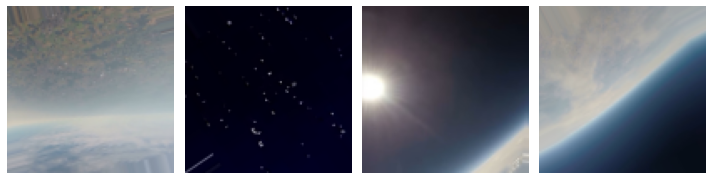

In [43]:
sample_training_images, labels= next(iter(train_ds))
print(labels[:4])
plotImages(sample_training_images[:4])

# Model definition

In [44]:
model_cnn = keras.models.Sequential()

model_cnn.add(keras.layers.Conv2D(32, (3,3), padding='same'))
model_cnn.add(keras.layers.BatchNormalization())
model_cnn.add(keras.layers.MaxPooling2D((2,2)))

model_cnn.add(keras.layers.Conv2D(64, (3,3), padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model_cnn.add(keras.layers.Activation(keras.activations.relu))
model_cnn.add(keras.layers.MaxPooling2D((2,2)))

model_cnn.add(keras.layers.Conv2D(128, (3,3), padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model_cnn.add(keras.layers.Activation(keras.activations.relu))
model_cnn.add(keras.layers.MaxPooling2D((2,2)))

model_cnn.add(keras.layers.Conv2D(128, (3,3), padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model_cnn.add(keras.layers.Activation(keras.activations.relu))
model_cnn.add(keras.layers.MaxPooling2D((4,4)))

model_cnn.add(keras.layers.Flatten())
model_cnn.add(keras.layers.Dense(32,  kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model_cnn.add(keras.layers.Dropout(0.5))
model_cnn.add(keras.layers.Activation(keras.layers.LeakyReLU()))
model_cnn.add(keras.layers.Dense(1, activation = "sigmoid"))

model_cnn.build((None, 100, 100, 3))
model_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 100, 100, 32)      896       
                                                                 
 batch_normalization_2 (Batc  (None, 100, 100, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 activation_8 (Activation)   (None, 50, 50, 64)        0         
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 25, 25, 64)      

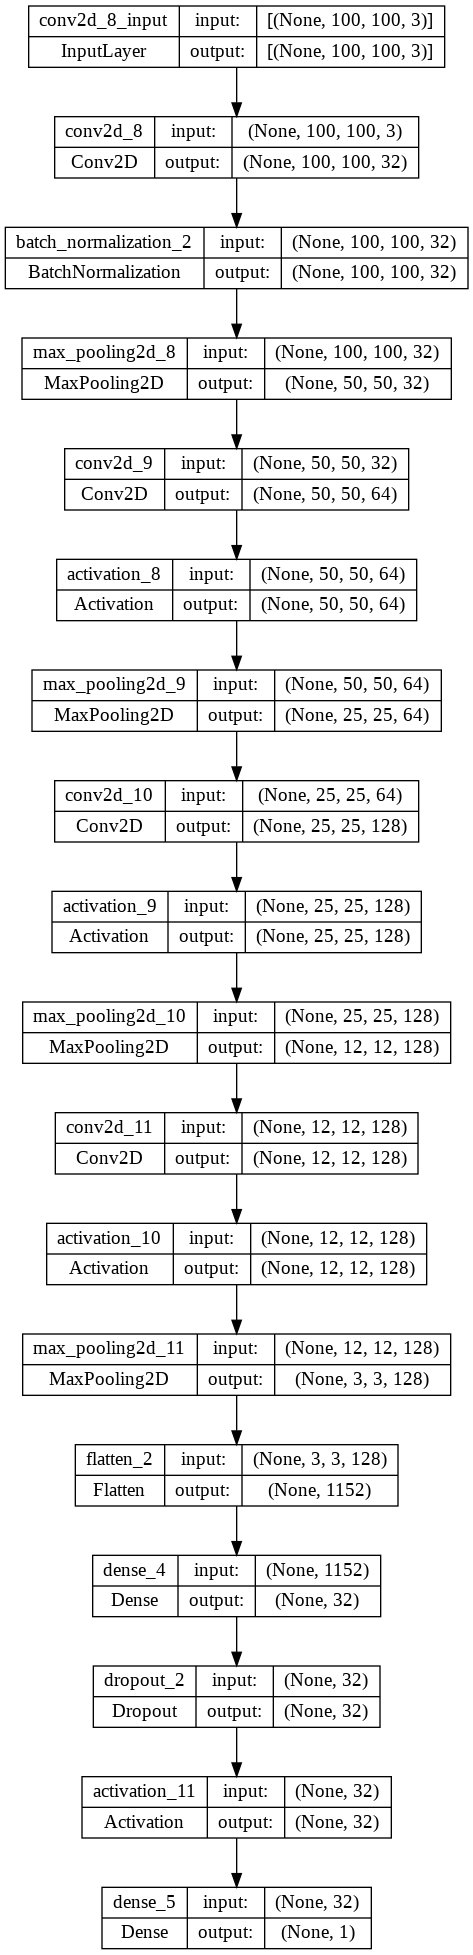

In [45]:
plot_model(model_cnn, to_file='model_cnn.png', show_shapes=True, show_layer_names=True)

In [46]:
optimizer = optimizers.Adam(
    learning_rate=0.00005,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam",
)


model_cnn.compile(loss='binary_crossentropy', optimizer =optimizer,
             metrics=['accuracy'])

# Model training

In [47]:
training_samples = train_ds.n
val_samples = val_ds.n

epochs = 100

history_cnn = model_cnn.fit(
    train_ds,
    steps_per_epoch=training_samples // batch_size,
    epochs = epochs,
    validation_data=val_ds,
    validation_steps=val_samples // batch_size,
)

Epoch 1/100
89/89 [==============================] - 47s 524ms/step - loss: 3.7271 - accuracy: 0.6657 - val_loss: 3.6898 - val_accuracy: 0.7159
Epoch 2/100
89/89 [==============================] - 42s 477ms/step - loss: 3.4815 - accuracy: 0.7416 - val_loss: 3.4986 - val_accuracy: 0.8494
Epoch 3/100
89/89 [==============================] - 43s 482ms/step - loss: 3.2765 - accuracy: 0.7921 - val_loss: 3.2946 - val_accuracy: 0.8267
Epoch 4/100
89/89 [==============================] - 44s 491ms/step - loss: 3.1252 - accuracy: 0.8153 - val_loss: 3.1046 - val_accuracy: 0.8608
Epoch 5/100
89/89 [==============================] - 43s 479ms/step - loss: 2.9993 - accuracy: 0.8230 - val_loss: 2.9452 - val_accuracy: 0.8466
Epoch 6/100
89/89 [==============================] - 43s 481ms/step - loss: 2.8730 - accuracy: 0.8413 - val_loss: 2.8587 - val_accuracy: 0.7898
Epoch 7/100
89/89 [==============================] - 47s 531ms/step - loss: 2.7788 - accuracy: 0.8378 - val_loss: 2.7017 - val_accuracy:

In [48]:
def visualizacion_resultados(history):
  nepochs = [i for i in range(epochs)]
  fig, ax = plt.subplots(1,2)
  train_acc = history.history["accuracy"]
  train_loss = history.history["loss"]
  val_acc = history.history["val_accuracy"]
  val_loss = history.history["val_loss"]
  fig.set_size_inches(16, 9)

  ax[0].plot(nepochs, train_acc, "-", label =" Training accuracy")
  ax[0].plot(nepochs, val_acc, "-", label= "Validation accuracy")
  ax[0].set_title("Training & validation accuracy")
  ax[0].legend()
  ax[0].set_xlabel("nEpochs")
  ax[0].set_ylabel("Accuracy")

  ax[1].plot(nepochs, train_loss, "go-", label =" Training Loss")
  ax[1].plot(nepochs, val_loss, "ro-", label= "Validation Loss")
  ax[1].set_title("Training & validation Loss")
  ax[1].legend()
  ax[1].set_xlabel("Epochs")
  ax[1].set_ylabel("Loss")

  plt.show()


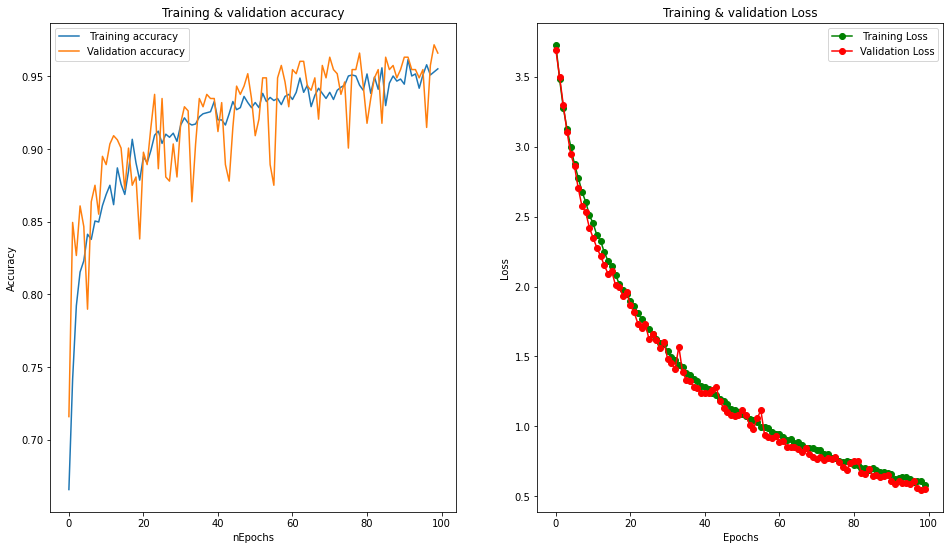

In [49]:
visualizacion_resultados(history_cnn)

# Tensorflow model evaluation

In [50]:
loss, accuracy = model_cnn.evaluate(test_ds)

26/26 [==============================] - 13s 491ms/step - loss: 0.7293 - accuracy: 0.9257


In [51]:
import time
sample_test_images, true_label_id = next(iter(test_ds))

start_time = time.time()
tf_model_predictions = model_cnn(sample_test_images)
end_time = time.time()

time_diff = end_time - start_time
print(f'Processing time: {round(time_diff*1000, 2)} ms')

Processing time: 8.33 ms


In [52]:
predicted_ids = []

for x in tf_model_predictions.numpy(): 
  if x > 0.5:
    predicted_ids.append(1)
  else: 
    predicted_ids.append(0)

print(predicted_ids)
print(true_label_id)

[1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1]
[1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1.]


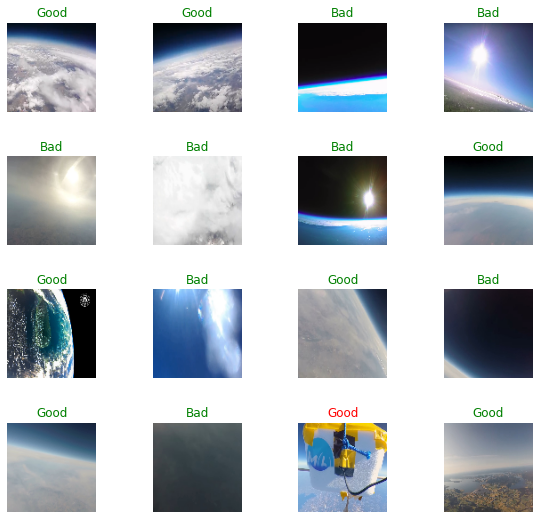

In [53]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(16):
  plt.subplot(4,4,n+1)
  plt.imshow(sample_test_images[n])
  color = "green" if predicted_ids[n] == true_label_id[n] else "red"
  if predicted_ids[n] == 1:
    text = 'Good'
  else:
    text = 'Bad'
  plt.title(text.title(), color=color)
  plt.axis('off')

In [54]:
!mkdir tf_models

model_cnn.save("tf_models/model_cnn.h5")
print("Tensorflow model size")
!ls "tf_models" -lh

mkdir: cannot create directory ‘tf_models’: File exists
Tensorflow model size
total 3.3M
-rw-r--r-- 1 root root 3.3M Oct 28 23:18 model_cnn.h5


# TFLite model quantization

In [60]:
!mkdir "tflite_quantized_models"
TFLITE_MODEL_QUANTIZED = "tflite_quantized_models/cnn_quantized_final.tflite"

mkdir: cannot create directory ‘tflite_quantized_models’: File exists


In [61]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(model_cnn)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()
open(TFLITE_MODEL_QUANTIZED, "wb").write(tflite_quant_model)

print("Tflite model size")
!ls "tflite_quantized_models" -lh

Tflite model size
total 568K
-rw-r--r-- 1 root root 284K Oct 28 23:19 cnn_quantized_final.tflite
-rw-r--r-- 1 root root 284K Oct 28 23:18 cnn_quantized.tflite


In [57]:
tflite_interpreter_quant = tf.lite.Interpreter(model_path=TFLITE_MODEL_QUANTIZED)

input_details = tflite_interpreter_quant.get_input_details()
output_details = tflite_interpreter_quant.get_output_details()

tflite_interpreter_quant.resize_tensor_input(input_details[0]['index'], (16, 100, 100, 3))
tflite_interpreter_quant.resize_tensor_input(output_details[0]['index'], (32, 5))
tflite_interpreter_quant.allocate_tensors()

input_details = tflite_interpreter_quant.get_input_details()
output_details = tflite_interpreter_quant.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

tflite_interpreter_quant.set_tensor(input_details[0]['index'], sample_test_images)

tflite_interpreter_quant.invoke()
start_time = time.time()
tflite_q_model_predictions = tflite_interpreter_quant.get_tensor(output_details[0]['index'])
end_time = time.time()

time_diff = end_time - start_time

print("\nPrediction results shape:", tflite_q_model_predictions.shape)
print(f'Processing time: {round(time_diff*1000, 2)} ms')

== Input details ==
name: serving_default_conv2d_8_input:0
shape: [ 16 100 100   3]
type: <class 'numpy.float32'>

== Output details ==
name: StatefulPartitionedCall:0
shape: [16  1]
type: <class 'numpy.float32'>

Prediction results shape: (16, 1)
Processing time: 0.12 ms


In [58]:
predicted_ids = []

for x in tflite_q_model_predictions: 
  if x > 0.5:
    predicted_ids.append(1)
  else: 
    predicted_ids.append(0)

print(predicted_ids)
print(true_label_id)

[1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1]
[1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1.]


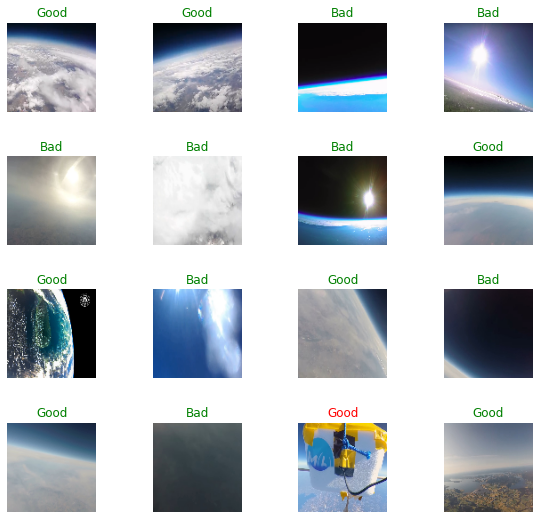

In [59]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(16):
  plt.subplot(4,4,n+1)
  plt.imshow(sample_test_images[n])
  color = "green" if predicted_ids[n] == true_label_id[n] else "red"
  if predicted_ids[n] == 1:
    text = 'Good'
  else:
    text = 'Bad'
  plt.title(text.title(), color=color)
  plt.axis('off')